In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

In [3]:
vocabulary_size = 5000
max_words = 500

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = vocabulary_size)

In [4]:
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}

In [5]:
X_train = sequence.pad_sequences(X_train, maxlen = max_words)
X_test = sequence.pad_sequences(X_test, maxlen = max_words)

embedding_size = 32

In [6]:
X_train_LSTM = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_train_LSTM.shape

(25000, 1, 500)

In [7]:
model1 = Sequential()
model1.add(LSTM(100, input_shape = (X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
model1.add(Dense(1, activation = 'sigmoid'))

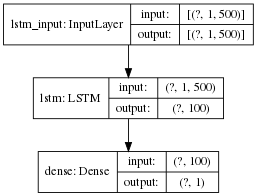

In [8]:
tf.keras.utils.plot_model(model1, show_shapes = True, dpi = 64)

In [9]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

batch_size = 64
num_epochs = 3

X_valid, y_valid = X_train_LSTM[:batch_size], y_train[:batch_size]  
X_train2, y_train2 = X_train_LSTM[batch_size:], y_train[batch_size:]

In [10]:
model1.fit(X_train2, y_train2,
          validation_data = (X_valid, y_valid),
          batch_size = batch_size, epochs = num_epochs)

Epoch 1/3
390/390 [==============================] - 3s 7ms/step - loss: 0.7129 - accuracy: 0.4972 - val_loss: 0.6898 - val_accuracy: 0.5469
Epoch 2/3
390/390 [==============================] - 2s 6ms/step - loss: 0.6975 - accuracy: 0.5059 - val_loss: 0.6988 - val_accuracy: 0.4844
Epoch 3/3
390/390 [==============================] - 2s 6ms/step - loss: 0.6930 - accuracy: 0.5161 - val_loss: 0.7000 - val_accuracy: 0.4688


In [11]:
model2 = Sequential()
model2.add(Embedding(vocabulary_size, embedding_size, input_length = max_words))
model2.add(LSTM(100))
model2.add(Dense(1, activation = 'sigmoid'))

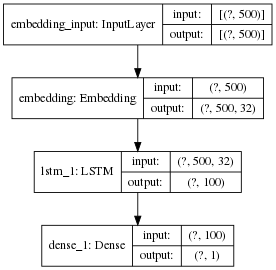

In [12]:
tf.keras.utils.plot_model(model2, show_shapes = True, dpi = 64)

In [13]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

batch_size = 64
num_epochs = 3

X_valid, y_valid = X_train[:batch_size], y_train[:batch_size]  
X_train2, y_train2 = X_train[batch_size:], y_train[batch_size:]

In [14]:
model2.fit(X_train2, y_train2,
          validation_data = (X_valid, y_valid),
          batch_size = batch_size, epochs = num_epochs)

Epoch 1/3
390/390 [==============================] - 13s 35ms/step - loss: 0.5029 - accuracy: 0.7476 - val_loss: 0.3363 - val_accuracy: 0.8594
Epoch 2/3
390/390 [==============================] - 13s 34ms/step - loss: 0.3228 - accuracy: 0.8684 - val_loss: 0.2863 - val_accuracy: 0.8750
Epoch 3/3
390/390 [==============================] - 13s 34ms/step - loss: 0.2667 - accuracy: 0.8963 - val_loss: 0.2541 - val_accuracy: 0.9219


In [15]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype = 'float32')

embeddings_index = dict(get_coefs(*o.strip().split()) for o in open('../../../Downloads/glove.6B.50d.txt','rb'))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = 50
embedding_matrix = np.random.normal(emb_mean, emb_std, (vocabulary_size, embed_size))

for word, i in word2id.items():
    if i >= vocabulary_size: 
        continue 
    embedding_vector = embeddings_index.get(word) 
    
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector 

/home/tanmay/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [16]:
model3 = Sequential()
model3.add(Embedding(vocabulary_size, embed_size, weights = [embedding_matrix], input_length = max_words, trainable = False))
model3.add(LSTM(100))
model3.add(Dense(1, activation = 'sigmoid'))

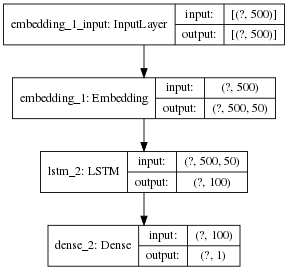

In [17]:
tf.keras.utils.plot_model(model3, show_shapes = True, dpi = 64)

In [18]:
model3.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model3.fit(X_train2, y_train2,
          validation_data = (X_valid, y_valid),
          batch_size = batch_size, epochs = 3)

Epoch 1/3
390/390 [==============================] - 12s 31ms/step - loss: 0.6306 - accuracy: 0.6393 - val_loss: 0.6210 - val_accuracy: 0.5781
Epoch 2/3
390/390 [==============================] - 12s 30ms/step - loss: 0.5634 - accuracy: 0.7105 - val_loss: 0.5576 - val_accuracy: 0.7500
Epoch 3/3
390/390 [==============================] - 12s 30ms/step - loss: 0.5083 - accuracy: 0.7483 - val_loss: 0.5579 - val_accuracy: 0.7188


In [19]:
idx = np.random.choice(X_train.shape[0])
review = " ".join([id2word[i] for i in X_train[idx] if i])
if model2.predict(np.reshape(X_train[idx], (1,-1))) < 0.5:
    label = 'negative'
else:
    label = 'positive'
print(review + '\n\nis ' + label)

the ignore and and and it of and war br is thought and like and and acting and no about order it age this is warning experiences go are is casting and desperately would it and br never empty movie about and into me cute will decide to her would there so and and viewing send richard and to so and park are about and out in at woman and smaller in and and in pleasant this about and not and are our that this pleasant is heaven i'd br songs send you've bob it years extremely in and game in caring about sort is offer br about order and and like asian camera film about and and game in car any give but is content br of sense for would and would it and in to as it know comes and direction gave be about process shall send movie it and film comes reality it they how and who of q happens to it titles his in cannot and who happens shape and and and is spent school this sadistic to and send it them and who of mix and and and and is entertainment cagney like gem made ridiculously of shall in why thin